(256, 256, 3) 1.0 0.0 (256, 256, 3) 0.99607843 0.003921569
Input	Proposal	baseline


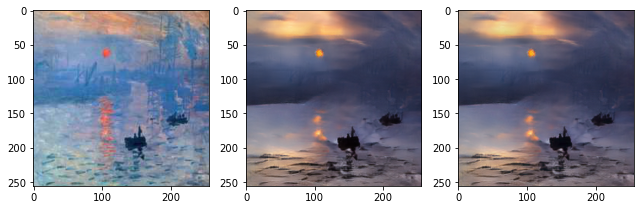

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import change_range, basic_normalization, change_range_tensor, norm_tensor, norm_numpy

def show_pair(pair):
    plt.figure(figsize=(3*len(pair), 3))
    for i, x in enumerate(pair):
        plt.subplot(1, len(pair), i + 1)
        plt.imshow(x)
    plt.tight_layout()
    plt.show()

trainA = plt.imread("trainA.png")
trainB = plt.imread("trainB.png")
use_both_a = True
alpha = 0.3
n_channels = 1
if trainA.max() > 1:
    trainA = trainA.astype(np.float) / 255.
if trainB.max() > 1:
    trainB = trainB.astype(np.float) / 255.
print(trainA.shape, trainA.max(), trainA.min(), trainB.shape, trainB.max(), trainB.min())

imgA = trainA * 255
imgB = trainB * 255
baseline_diff = trainB - trainA * alpha
baseline = (trainA * alpha + np.minimum(np.maximum(baseline_diff, 0), 1 - alpha)) * 255

print("Input\tProposal\tbaseline")
pair = (trainA, trainB, baseline / 255.)
show_pair(pair)

# Gradient descent on the offset variable

<IPython.core.display.Javascript object>


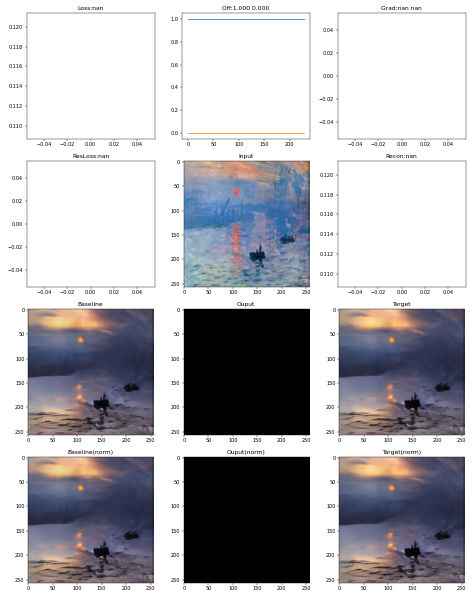

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt


figsize = 4
r, c = 4, 3
fig = plt.figure(figsize=(c * figsize, r * figsize))
ax1 = fig.add_subplot(r, c, 1)
ax1.plot([], [])
ax1.set_title("Loss")

ax2 = fig.add_subplot(r, c, 2)
ax2.plot([], [])
ax2.set_title("Offset")

ax4 = fig.add_subplot(r, c, 3)
ax4.plot([], [])
ax4.set_title("Gradient")

ax3 = fig.add_subplot(r, c, 4)
ax3.plot([], [])
ax3.set_title("ResLoss")

ax7 = fig.add_subplot(r, c, 6)
ax7.plot([], [])
ax7.set_title("Recon")

###################
# Original view
###################

axinp = fig.add_subplot(r, c, 5)
axinp.imshow(imgA.astype(np.int))
axinp.set_title("Input")

axtrg = fig.add_subplot(r, c, 9)
axtrg.imshow(imgB.astype(np.int))
axtrg.set_title("Target")

axbase = fig.add_subplot(r, c, 7)
axbase.imshow(baseline.astype(np.int))
axbase.set_title("Baseline")

ax6 = fig.add_subplot(r, c, 8)
ax6.imshow(imgA.astype(np.int))
ax6.set_title("Output")

###################
# Normalized view
###################

axbase_norm = fig.add_subplot(r, c, 10)
axbase_norm.imshow(norm_numpy(baseline).astype(np.int))
axbase_norm.set_title("Baseline(norm)")

ax6_norm = fig.add_subplot(r, c, 11)
ax6_norm.imshow(imgA.astype(np.int))
ax6_norm.set_title("Output(norm)")

axtrg_norm = fig.add_subplot(r, c, 12)
axtrg_norm.imshow(norm_numpy(imgB).astype(np.int))
axtrg_norm.set_title("Target(norm)")

plt.tight_layout()
plt.show()




In [81]:
# Poisson Image Editing
# equation 3
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Gradient_Net(nn.Module):
    def __init__(self):

        super(Gradient_Net, self).__init__()
        kernel_x = [[1., 0., -1.], [2., 0., -2.], [1., 0., -1.]]
        # kernel_x = [[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]
        kernel_x = torch.FloatTensor(kernel_x).unsqueeze(0).unsqueeze(0)
        kernel_y = [[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]]
        # kernel_y = [[-3, -10, -3], [0, 0, 0], [3, 10, 3]]
        kernel_y = torch.FloatTensor(kernel_y).unsqueeze(0).unsqueeze(0)
        self.weight_x = nn.Parameter(data=kernel_x, requires_grad=False)
        self.weight_y = nn.Parameter(data=kernel_y, requires_grad=False)
        # self.grad = torch.cat([self.weight_x, self.weight_y])
        
    def forward(self, x):
        # x: 1 * 256 * 256 * 3
        grad_out = []
        # print(x.shape)
        for channel in range(x.shape[-1]):
            # 1 * 1 * 256 * 256 
            # x_i = x[:, :, channel].unsqueeze(1)
            x_i = x[:, :, :, channel].unsqueeze(1)
            # set bias = False 
            grad_x = F.conv2d(x_i, self.weight_x, padding = 1)
            grad_y = F.conv2d(x_i, self.weight_y, padding = 1)
            grad = torch.sqrt(grad_x ** 2 + grad_y ** 2)
            # print(grad.shape, 'grad shape')
            # grad_x, grad_y : 1 * 2 * 256 * 256
            # gradient = torch.cat([grad_x, grad_y], dim = 1)
            # grad_out.append(gradient)
            grad_out.append(grad)
        # print(grad_out.shape)
        # bs * (channel * 2) * h * w
        return torch.cat(grad_out, dim=1)
        #return grad_out
        # return torch.stack(grad_out, -1).squeeze(0)

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm


lr = 1e-3

# change into singel param
a = nn.Parameter(torch.ones(1, 1, n_channels))
b = nn.Parameter(torch.zeros(1, 1, n_channels))

residual = nn.Parameter(torch.zeros(256, 256, 3), requires_grad = True)
    
# optim = Adam([a, b], lr=lr)
optim = Adam([residual], lr = lr)
total_iters = 1000
resloss_weight = 10
losses = []
offsets = []
res_losses = []
offset_grads = []
recon_losses = []

grad_net = Gradient_Net()

for i in tqdm.tqdm(range(total_iters)):
    optim.zero_grad()
    A_tensor = torch.from_numpy(trainA).float()  # input
    A_rescaled = change_range_tensor(A_tensor, alpha, 0.) # input after sunglasses: alpha * input
    B_tensor = torch.from_numpy(trainB).float()  # target/psedo-label
    
    B_rescaled = B_tensor * a + b
    
    # residual = B_rescaled - A_rescaled
    # change residual -> param 
    # print(a, b)
    # residual = torch.sigmoid(residual)
    
    clipped_residual = torch.clamp(residual, min=0, max=1 - alpha)
    real_output = clipped_residual + A_rescaled

    # 1*6*256*256
    grad_b = grad_net(B_rescaled.view((1, 256, 256, 3)))
    grad_a = grad_net(real_output.view((1, 256, 256, 3)))
    # 1*6*256*256
    recon_loss_all = torch.abs(grad_b - grad_a)
    recon_loss = recon_loss_all.mean() #(recon_loss_all * random_mask).sum() / (random_mask.sum() + 1e-10)
    random_mask = torch.ones_like(residual)
    residual_loss = (torch.abs(clipped_residual - residual) * random_mask).mean()
    
    loss = recon_loss + residual_loss * resloss_weight
    loss.backward(retain_graph=True)
    
    offset_grads.append((
        a.grad.clone().norm().item() if a.grad is not None else 0, 
        b.grad.clone().norm().item() if b.grad is not None else 0, 
        residual.grad.clone().norm().item() if residual.grad is not None else 0.))
    optim.step()

    losses.append(loss.item())
    offsets.append((a.clone().detach().mean().item(), b.clone().detach().mean().item(), residual.clone().detach().mean().item()))
    # offsets.append((residual.clone().detach().mean().item()))
    recon_losses.append(recon_loss.clone().detach().item())
    print(len(offsets))
    res_losses.append(residual_loss)
    if (i + 1) % 10 == 0:
        ax1.clear()
        ax1.plot(range(len(losses)), losses)
        ax1.set_title("Loss:%.6f" % losses[-1])
        
        ax2.clear()
        ax2.plot(range(len(offsets)), [offfff[0] for offfff in offsets], label="a")
        ax2.plot(range(len(offsets)), [offfff[1] for offfff in offsets], label="b")
        ax2.set_title("Off:%.3f %.3f" % (offsets[-1][0], offsets[-1][1]))
        
        ax3.clear()
        ax3.plot(range(len(res_losses)), res_losses)
        ax3.set_title("ResLoss:%.6f" % res_losses[-1])
        
        ax4.clear()
        ax4.plot(range(len(offset_grads)), [offfff[0] for offfff in offset_grads], label="a")
        ax4.plot(range(len(offset_grads)), [offfff[1] for offfff in offset_grads], label="b")
        ax4.set_title("Grad:%.3f %.3f" % (offset_grads[-1][0], offset_grads[-1][1])) 
        
        ax7.clear()
        ax7.plot(range(len(recon_losses)), recon_losses)
        ax7.set_title("Recon:%.6f" % recon_losses[-1])
        
        ax6_norm.clear()
        ax6_norm.imshow((norm_tensor(real_output).cpu().detach().numpy() * 255.).astype(np.int))
        ax6_norm.set_title("Ouput(norm)")
        
        ax6.clear()
        ax6.imshow((real_output.cpu().detach().numpy() * 255.).astype(np.int))
        ax6.set_title("Ouput")
        fig.canvas.draw()



  0%|          | 2/1000 [00:00<03:35,  4.62it/s]

1
2


  0%|          | 4/1000 [00:00<02:59,  5.56it/s]

3
4


  1%|          | 6/1000 [00:01<02:44,  6.03it/s]

5
6


  1%|          | 8/1000 [00:01<02:49,  5.85it/s]

7
8


  1%|          | 9/1000 [00:01<02:56,  5.61it/s]

9
10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  1%|          | 12/1000 [00:02<04:40,  3.52it/s]

11
12


  1%|▏         | 14/1000 [00:03<03:34,  4.60it/s]

13
14


  2%|▏         | 16/1000 [00:03<03:03,  5.36it/s]

15
16


  2%|▏         | 18/1000 [00:03<02:50,  5.76it/s]

17
18


  2%|▏         | 19/1000 [00:03<02:47,  5.84it/s]

19
20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  2%|▏         | 22/1000 [00:05<04:52,  3.34it/s]

21
22


  2%|▏         | 24/1000 [00:05<03:58,  4.09it/s]

23
24


  3%|▎         | 26/1000 [00:06<03:36,  4.50it/s]

25
26


  3%|▎         | 28/1000 [00:06<03:24,  4.75it/s]

27
28


  3%|▎         | 29/1000 [00:06<03:23,  4.77it/s]

29
30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  3%|▎         | 32/1000 [00:07<04:38,  3.47it/s]

31
32


  3%|▎         | 34/1000 [00:08<03:38,  4.42it/s]

33
34


  4%|▎         | 36/1000 [00:08<03:07,  5.14it/s]

35
36


  4%|▍         | 38/1000 [00:08<02:52,  5.58it/s]

37
38


  4%|▍         | 39/1000 [00:09<02:51,  5.61it/s]

39
40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  4%|▍         | 42/1000 [00:10<04:07,  3.87it/s]

41
42


  4%|▍         | 44/1000 [00:10<03:13,  4.94it/s]

43
44


  5%|▍         | 46/1000 [00:10<02:46,  5.73it/s]

45
46


  5%|▍         | 48/1000 [00:11<02:30,  6.31it/s]

47
48


  5%|▍         | 49/1000 [00:11<02:21,  6.73it/s]

49
50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  5%|▌         | 52/1000 [00:12<04:02,  3.91it/s]

51
52


  5%|▌         | 53/1000 [00:12<03:21,  4.69it/s]

53
54


  6%|▌         | 56/1000 [00:12<02:36,  6.03it/s]

55
56


  6%|▌         | 57/1000 [00:12<02:21,  6.68it/s]

57
58


  6%|▌         | 59/1000 [00:13<02:08,  7.31it/s]

59
60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  6%|▌         | 62/1000 [00:14<04:05,  3.82it/s]

61
62


  6%|▋         | 64/1000 [00:14<03:11,  4.88it/s]

63
64


  7%|▋         | 66/1000 [00:15<02:47,  5.58it/s]

65
66


  7%|▋         | 68/1000 [00:15<02:37,  5.93it/s]

67
68


  7%|▋         | 69/1000 [00:15<02:39,  5.85it/s]

69
70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  7%|▋         | 72/1000 [00:16<04:28,  3.46it/s]

71
72


  7%|▋         | 74/1000 [00:17<03:26,  4.48it/s]

73
74


  8%|▊         | 76/1000 [00:17<02:51,  5.39it/s]

75
76


  8%|▊         | 78/1000 [00:17<02:32,  6.05it/s]

77
78


  8%|▊         | 79/1000 [00:17<02:25,  6.33it/s]

79
80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  8%|▊         | 82/1000 [00:19<04:00,  3.82it/s]

81
82


  8%|▊         | 84/1000 [00:19<03:10,  4.82it/s]

83
84


  9%|▊         | 86/1000 [00:19<02:47,  5.46it/s]

85
86


  9%|▉         | 88/1000 [00:19<02:30,  6.04it/s]

87
88


  9%|▉         | 89/1000 [00:20<02:25,  6.28it/s]

89
90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  9%|▉         | 92/1000 [00:21<04:03,  3.73it/s]

91
92


  9%|▉         | 94/1000 [00:21<03:11,  4.74it/s]

93
94


 10%|▉         | 96/1000 [00:21<02:43,  5.52it/s]

95
96


 10%|▉         | 98/1000 [00:22<02:34,  5.82it/s]

97
98


 10%|▉         | 99/1000 [00:22<02:35,  5.81it/s]

99
100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█         | 101/1000 [00:23<04:54,  3.05it/s]

101


 10%|█         | 102/1000 [00:23<04:27,  3.35it/s]

102


 10%|█         | 104/1000 [00:24<03:38,  4.10it/s]

103
104


 10%|█         | 105/1000 [00:24<03:22,  4.42it/s]

105


 11%|█         | 107/1000 [00:24<03:10,  4.70it/s]

106
107


 11%|█         | 108/1000 [00:24<03:06,  4.77it/s]

108


 11%|█         | 109/1000 [00:25<03:07,  4.76it/s]

109
110


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 11%|█         | 112/1000 [00:26<04:21,  3.39it/s]

111
112


 11%|█▏        | 114/1000 [00:26<03:23,  4.36it/s]

113
114


 12%|█▏        | 116/1000 [00:27<02:51,  5.16it/s]

115
116


 12%|█▏        | 118/1000 [00:27<02:35,  5.67it/s]

117
118


 12%|█▏        | 119/1000 [00:27<02:35,  5.68it/s]

119
120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 12%|█▏        | 122/1000 [00:28<03:44,  3.91it/s]

121
122


 12%|█▏        | 124/1000 [00:28<03:01,  4.83it/s]

123
124


 13%|█▎        | 126/1000 [00:29<02:43,  5.36it/s]

125
126


 13%|█▎        | 128/1000 [00:29<02:30,  5.78it/s]

127
128


 13%|█▎        | 129/1000 [00:29<02:27,  5.92it/s]

129
130


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 13%|█▎        | 132/1000 [00:30<03:43,  3.88it/s]

131
132


 13%|█▎        | 134/1000 [00:31<02:59,  4.84it/s]

133
134


 14%|█▎        | 136/1000 [00:31<02:42,  5.31it/s]

135
136


 14%|█▍        | 138/1000 [00:31<02:35,  5.55it/s]

137
138


 14%|█▍        | 139/1000 [00:32<02:32,  5.65it/s]

139
140


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 14%|█▍        | 141/1000 [00:33<04:55,  2.91it/s]

141


 14%|█▍        | 142/1000 [00:33<04:20,  3.30it/s]

142


 14%|█▍        | 143/1000 [00:33<04:01,  3.55it/s]

143


 14%|█▍        | 144/1000 [00:33<03:40,  3.88it/s]

144


 14%|█▍        | 145/1000 [00:34<03:32,  4.02it/s]

145


 15%|█▍        | 146/1000 [00:34<03:24,  4.18it/s]

146


 15%|█▍        | 147/1000 [00:34<03:19,  4.28it/s]

147


 15%|█▍        | 148/1000 [00:34<03:15,  4.36it/s]

148


 15%|█▍        | 149/1000 [00:34<03:08,  4.51it/s]

149
150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 15%|█▌        | 152/1000 [00:36<04:18,  3.27it/s]

151
152


 15%|█▌        | 154/1000 [00:36<03:26,  4.09it/s]

153
154


 16%|█▌        | 156/1000 [00:36<02:51,  4.94it/s]

155
156


 16%|█▌        | 158/1000 [00:37<02:34,  5.45it/s]

157
158


 16%|█▌        | 159/1000 [00:37<02:26,  5.74it/s]

159
160


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 16%|█▌        | 162/1000 [00:38<03:54,  3.57it/s]

161
162


 16%|█▋        | 163/1000 [00:38<03:34,  3.90it/s]

163


 16%|█▋        | 164/1000 [00:39<03:23,  4.11it/s]

164


 17%|█▋        | 166/1000 [00:39<03:05,  4.50it/s]

165
166


 17%|█▋        | 168/1000 [00:39<02:36,  5.33it/s]

167
168


 17%|█▋        | 169/1000 [00:39<02:23,  5.79it/s]

169
170


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 17%|█▋        | 172/1000 [00:41<03:57,  3.49it/s]

171
172


 17%|█▋        | 174/1000 [00:41<03:00,  4.59it/s]

173
174


 18%|█▊        | 176/1000 [00:41<02:36,  5.27it/s]

175
176


 18%|█▊        | 178/1000 [00:42<02:17,  6.00it/s]

177
178


 18%|█▊        | 179/1000 [00:42<02:12,  6.19it/s]

179
180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 18%|█▊        | 182/1000 [00:43<03:44,  3.64it/s]

181
182


 18%|█▊        | 184/1000 [00:43<02:51,  4.76it/s]

183
184


 19%|█▊        | 186/1000 [00:44<02:27,  5.51it/s]

185
186


 19%|█▉        | 188/1000 [00:44<02:17,  5.90it/s]

187
188


 19%|█▉        | 189/1000 [00:44<02:15,  6.00it/s]

189
190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 19%|█▉        | 192/1000 [00:45<03:18,  4.07it/s]

191
192


 19%|█▉        | 194/1000 [00:45<02:50,  4.74it/s]

193
194


 20%|█▉        | 196/1000 [00:46<02:33,  5.22it/s]

195
196


 20%|█▉        | 198/1000 [00:46<02:29,  5.36it/s]

197
198


 20%|█▉        | 199/1000 [00:46<02:26,  5.46it/s]

199
200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|██        | 201/1000 [00:47<04:28,  2.98it/s]

201
202


 20%|██        | 204/1000 [00:48<03:12,  4.14it/s]

203
204


 21%|██        | 206/1000 [00:48<02:22,  5.57it/s]

205
206


 21%|██        | 208/1000 [00:48<02:11,  6.03it/s]

207
208


 21%|██        | 209/1000 [00:49<02:12,  5.95it/s]

209
210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 21%|██        | 212/1000 [00:50<03:19,  3.94it/s]

211
212


 21%|██▏       | 213/1000 [00:50<02:54,  4.51it/s]

213


 22%|██▏       | 215/1000 [00:50<02:47,  4.69it/s]

214
215


 22%|██▏       | 217/1000 [00:50<02:12,  5.91it/s]

216
217


 22%|██▏       | 219/1000 [00:51<01:53,  6.86it/s]

218
219
220


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 22%|██▏       | 222/1000 [00:52<03:25,  3.78it/s]

221
222


 22%|██▏       | 224/1000 [00:52<02:44,  4.71it/s]

223
224


 23%|██▎       | 226/1000 [00:53<02:25,  5.31it/s]

225
226


 23%|██▎       | 228/1000 [00:53<02:15,  5.69it/s]

227
228


 23%|██▎       | 229/1000 [00:53<02:13,  5.76it/s]

229
230


 23%|██▎       | 229/1000 [00:53<03:01,  4.25it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


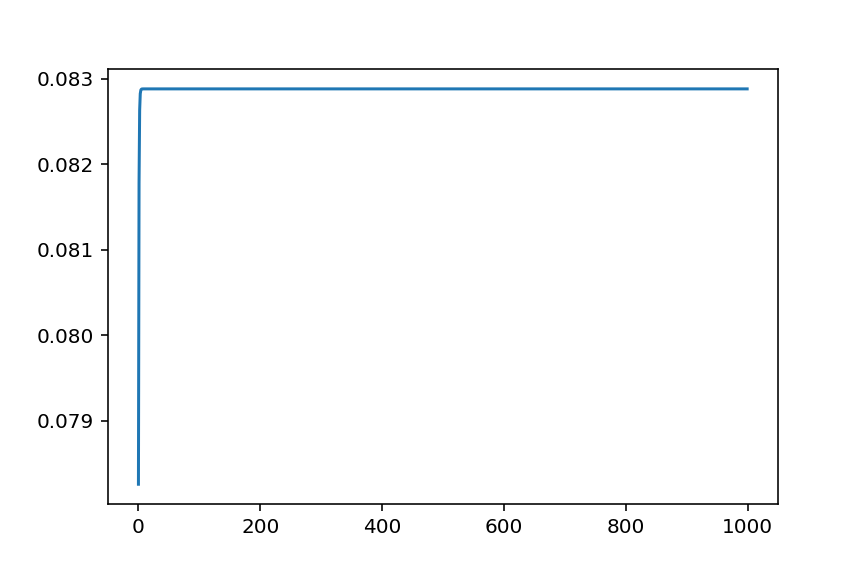

In [15]:
plt.plot(range(len(recon_losses)), recon_losses)
plt.show()

In [21]:
plt.imshow(real_output.detach().numpy())
plt.show()

In [17]:
print((residual - clipped_residual).min(), (residual - clipped_residual).max())

tensor(-0.1007, grad_fn=<MinBackward1>) tensor(0.2007, grad_fn=<MaxBackward1>)


In [22]:
print(residual.min(),residual.max(),
clipped_residual.min(), clipped_residual.max())

tensor(-0.1007, grad_fn=<MinBackward1>) tensor(0.5007, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>) tensor(0.3000, grad_fn=<MaxBackward1>)


In [ ]:
# image_path= 'Images/'
# files = os.listdir(image_path)
# seen = {}
# for file in files:
#     # print(file)
#     file_split = file.split('_')
#     if 'A' in file_split and file not in seen:
#         # find corresponding B
#         B_file = file.replace('A', 'B')
#         print(file, B_file)
#         seen[file] = B_file

# for k, v in seen.items():
#     imgA = plt.imread(image_path + k)
#     imgB = plt.imread(image_path + v)
#     everything(imgA, imgB)

In [4]:
import cv2

from scipy import ndimage
def gradient_field(img):
    img = np.float32(img)
    grad_y = cv2.Sobel(img,  cv2.CV_64F, 0, 1, ksize=3, borderType = cv2.BORDER_CONSTANT)
    grad_x = cv2.Sobel(img,  cv2.CV_64F, 1, 0, ksize=3, borderType = cv2.BORDER_CONSTANT)
    return np.stack([grad_x, grad_y], axis=0)

In [5]:
cv2grad = gradient_field(trainA[..., :1])
print(trainA.min(), trainA.max())
print(cv2grad.shape)
print(cv2grad.min(), cv2grad.max())

0.0 1.0
(2, 256, 256)
-2.788235366344452 3.972549021244049


In [84]:
grad_net = Gradient_Net()
print(trainA[..., :1].shape)
grad_A = grad_net(torch.from_numpy(trainA[..., :1]).view(1, 256, 256, 1))
# grad_A = grad_net(torch.from_numpy(trainA[..., :1]))#.view(1, 256, 256, 1))
print(A_tensor.min(), A_tensor.max())
print(grad_A.shape)
print(grad_A.min(), grad_A.max())

(256, 256, 1)
tensor(0.) tensor(1.)
torch.Size([1, 1, 256, 256])
tensor(0.) tensor(3.9734)


<IPython.core.display.Javascript object>


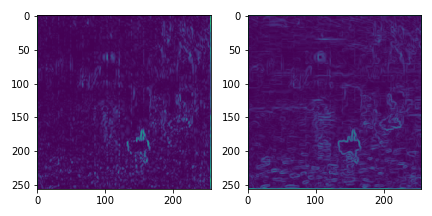

[[2.16078436 2.86666673 2.84313732 ... 2.34509814 2.38823539 1.86666673]
 [0.17647058 0.15686274 0.02745098 ... 0.03921568 0.14117646 0.11372548]
 [0.0745098  0.10588235 0.10588235 ... 0.09019607 0.01176471 0.07058823]
 ...
 [0.12156862 0.1490196  0.15294117 ... 0.07058823 0.09411764 0.05490196]
 [0.14117646 0.07843137 0.03137255 ... 0.16862744 0.16470587 0.11372548]
 [1.91764712 2.54117656 2.54901969 ... 1.68235296 1.62352943 1.20784315]] [[[3.0172386  2.86712    2.8437457  ... 2.3457406  2.395337   2.6013336 ]
  [2.8720932  0.15861751 0.03373455 ... 0.05545918 0.26107162 2.343937  ]
  [2.9381998  0.13413832 0.13909139 ... 0.1577427  0.12994549 2.3069627 ]
  ...
  [2.6263447  0.19996168 0.15419327 ... 0.14398079 0.127677   1.6714902 ]
  [2.57642    0.09146585 0.05022049 ... 0.23299538 0.17919467 1.600125  ]
  [2.7175143  2.541479   2.5496109  ... 1.6867394  1.6242113  1.669778  ]]]


In [86]:
show_pair([np.abs(cv2grad[0,:,:]), np.abs(grad_A[0,0,:,:])])
print(np.abs(cv2grad[1,:,:]), np.abs(grad_A[:,0,:,:].numpy()))